# Merit Matrix Monte Carlo Results - Exploratory Data Analysis

**Цель анализа:** Валидация результатов Monte Carlo симуляций и определение критических порогов для надежного использования метода агрегированных распределений в расчете бюджета повышений.

**Ключевые вопросы исследования:**
1. При каком размере группы метод становится надежным (success rate ≥ 80%)?
2. Какие параметры merit matrix наиболее влияют на успешность метода?
3. Какой уровень уверенности мы можем дать бизнесу для разных размеров групп?

**Структура анализа:**
- **Section 1-6:** Univariate analysis — влияние отдельных факторов на success rate
- **Section 7:** Correlation analysis — взаимосвязи между параметрами
- **Section 8-9:** Threshold detection — поиск критических порогов размера группы
- **Section 10:** Sophisticated methods — академические методы определения порогов (piecewise regression, AICc)
- **Section 11:** Reliability analysis — оценка уверенности и worst-case scenarios

---

## Setup and Configuration

### Библиотеки для статистического анализа

**Научные вычисления:**
- `pandas` — обработка табличных результатов Monte Carlo
- `numpy` — численные операции и массивы

**Визуализация:**
- `matplotlib` — базовые графики
- `seaborn` — продвинутые визуализации (heatmaps, correlation matrices)

**Статистика и оптимизация:**
- `scipy.optimize.minimize` — оптимизация для piecewise regression
- `scipy.stats` — корреляционный анализ (Pearson), kernel density estimation
- `sklearn.metrics` — метрики качества (MSE для regression)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde
import warnings

warnings.filterwarnings('ignore')

## Data Loading and Overview

Загружаем результаты Monte Carlo симуляций из parquet файла. Каждая строка представляет одну группу сотрудников (Company × Function) с результатами 50,000 итераций.

**Ключевые метрики в датасете:**
- `success_rate_pct` — % симуляций, попавших в диапазон ±5% от целевого бюджета
- `n_employees` — размер группы (количество сотрудников)
- `n_cr_bins` — количество CR bins в merit matrix (2-7)
- `n_ratings` — количество рейтингов производительности (3-7)
- `distribution_type` — тип распределения рейтингов (uniform, normal, skewed_low, skewed_high)
- `heuristic_budget_pct` — целевой бюджет, рассчитанный метом агрегированных распеределений

In [2]:
# Download the data
df = pd.read_parquet('ALL_results.parquet')

## 1. Success Rate by Number of CR Bins

**Гипотеза:** Более детальная сегментация по Compa-Ratio (больше bins) может улучшить точность метода за счет более точного учета позиции сотрудника относительно рынка.

**Ожидания:**
- Слишком мало bins (2-3) → грубая сегментация → низкая точность
- Оптимальное количество (4-5) → баланс точности и стабильности
- Слишком много bins (6-7) → переобучение → нестабильность на малых группах

**Метрика:** Mean success rate по всем группам для каждого количества CR bins

In [3]:
print("="*80)
print("MERIT MATRIX ANALYSIS - EXPLORATORY DATA ANALYSIS")
print("="*80)
print(f"Total observations: {len(df):,}")
print(f"Unique configurations: {df['config_name'].nunique()}")

MERIT MATRIX ANALYSIS - EXPLORATORY DATA ANALYSIS
Total observations: 350,520
Unique configurations: 120


In [4]:
# ============================================================================
# 1. SUCCESS BY NUMBER OF CR BINS
# ============================================================================
print("\n" + "="*80)
print("1. SUCCESS RATE BY NUMBER OF CR BINS")
print("="*80)

cr_summary = df.groupby('n_cr_bins')['success_rate_pct'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
cr_summary.columns = ['N Groups', 'Mean', 'Std Dev', 'Min', 'Max']
print(cr_summary)


1. SUCCESS RATE BY NUMBER OF CR BINS
           N Groups   Mean  Std Dev  Min    Max
n_cr_bins                                      
2             58420  49.52    23.62  0.0  100.0
3             58420  52.84    22.86  0.0  100.0
4             58420  50.78    23.08  0.0  100.0
5             58420  52.82    22.87  0.0  100.0
6             58420  51.56    23.00  0.0  100.0
7             58420  52.84    22.86  0.0  100.0


## 2. Success Rate by Number of Ratings

**Гипотеза:** Количество рейтингов производительности влияет на дифференциацию повышений. Больше рейтингов = более детальная дифференциация = потенциально выше точность.

**Практический контекст:**
- 3 рейтинга: упрощенная система (Below/Meets/Exceeds)
- 5 рейтингов: стандартная практика в большинстве компаний
- 7 рейтингов: детальная система с риском "grade inflation"

**Trade-off:** Детализация vs. сложность распределения рейтингов менеджерами

In [5]:
# ============================================================================
# 2. SUCCESS BY NUMBER OF RATINGS
# ============================================================================
print("\n" + "="*80)
print("2. SUCCESS RATE BY NUMBER OF RATINGS")
print("="*80)

rating_summary = df.groupby('n_ratings')['success_rate_pct'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
rating_summary.columns = ['N Groups', 'Mean', 'Std Dev', 'Min', 'Max']
print(rating_summary)


2. SUCCESS RATE BY NUMBER OF RATINGS
           N Groups   Mean  Std Dev   Min    Max
n_ratings                                       
3             70104  49.14    23.77  0.00  100.0
4             70104  50.72    23.07  0.17  100.0
5             70104  51.08    22.60  5.29  100.0
6             70104  53.57    22.93  1.82  100.0
7             70104  54.13    22.65  7.55  100.0


## 3. Success Rate by Distribution Type

**Цель:** Оценить, насколько тип распределения рейтингов влияет на точность метода.

**Типы распределений:**
- `uniform` — равномерное распределение рейтингов (базовый случай)
- `normal` — нормальное распределение (большинство в середине)
- `skewed_low` — смещение к низким рейтингам (строгие менеджеры)
- `skewed_high` — смещение к высоким рейтингам (grade inflation)

**Ожидания:** 
- Normal distribution должна работать лучше всего (типичная практика)
- Skewed distributions могут создавать проблемы концентрации бюджета

In [6]:
# ============================================================================
# 3. SUCCESS BY DISTRIBUTION TYPE
# ============================================================================
print("\n" + "="*80)
print("3. SUCCESS RATE BY DISTRIBUTION TYPE")
print("="*80)

dist_summary = df.groupby('distribution_type')['success_rate_pct'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
dist_summary.columns = ['N Groups', 'Mean', 'Std Dev', 'Min', 'Max']
dist_summary = dist_summary.sort_values('Mean', ascending=False)
print(dist_summary)


3. SUCCESS RATE BY DISTRIBUTION TYPE
                   N Groups   Mean  Std Dev   Min    Max
distribution_type                                       
skewed_high           87630  61.64    21.06  0.00  100.0
normal                87630  60.15    20.73  0.33  100.0
uniform               87630  44.58    21.60  0.17  100.0
skewed_low            87630  40.53    21.12  0.00  100.0


## 4. Success Rate by Matrix Size (CR Bins × Ratings)

**Цель:** Найти оптимальную размерность merit matrix через heatmap анализ.

**Интерпретация heatmap:**
- **Зеленый** (>60%): Конфигурация работает хорошо
- **Желтый** (40-60%): Пограничная зона — требуется большой размер группы
- **Красный** (<40%): Конфигурация ненадежна даже для больших групп

**Практический вывод:** Идентификация "sweet spot" для дизайна merit matrix

In [7]:
# ============================================================================
# 4. SUCCESS BY MATRIX SIZE (CR × RATINGS)
# ============================================================================
print("\n" + "="*80)
print("4. SUCCESS RATE BY MATRIX SIZE (CR BINS × RATINGS)")
print("="*80)

matrix_summary = df.groupby(['n_cr_bins', 'n_ratings'])['success_rate_pct'].mean().unstack().round(1)
matrix_summary.columns.name = 'N Ratings'
matrix_summary.index.name = 'N CR Bins'
print(matrix_summary)


4. SUCCESS RATE BY MATRIX SIZE (CR BINS × RATINGS)
N Ratings     3     4     5     6     7
N CR Bins                              
2          47.0  48.5  48.9  51.4  51.8
3          50.2  51.8  52.2  54.6  55.3
4          48.2  49.8  50.1  52.7  53.1
5          50.2  51.8  52.2  54.6  55.3
6          49.0  50.6  50.9  53.4  54.0
7          50.2  51.8  52.2  54.7  55.3


## 5. Success Rate by Group Size (Number of Employees)

**КРИТИЧЕСКИЙ АНАЛИЗ** — самый важный фактор для бизнес-рекомендаций.

**Вопрос:** При каком размере группы метод становится надежным?

**Размерные категории:**
- `0-20`: Очень малые группы — высокая вариативность
- `21-50`: Малые группы — метод еще нестабилен
- `51-100`: Средние группы — начало стабилизации
- `101-200`: Крупные группы — хорошая точность
- `201-500`: Очень крупные — высокая надежность
- `500+`: Мега-группы — максимальная стабильность

**Метрики:**
- Mean success rate по размерной категории
- Std Dev — вариабельность внутри категории
- Avg N Employees — средний размер группы в категории

In [8]:
# ============================================================================
# 5. SUCCESS BY GROUP SIZE (NUMBER OF EMPLOYEES)
# ============================================================================
print("\n" + "="*80)
print("5. SUCCESS RATE BY GROUP SIZE")
print("="*80)

size_bins = [0, 20, 50, 100, 200, 500, np.inf]
size_labels = ['0-20', '21-50', '51-100', '101-200', '201-500', '500+']
df['size_bin'] = pd.cut(df['n_employees'], bins=size_bins, labels=size_labels)

size_summary = df.groupby('size_bin')['success_rate_pct'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
size_summary.columns = ['N Groups', 'Mean', 'Std Dev', 'Min', 'Max']
print(size_summary)

# Also show average group size per bin
avg_employees = df.groupby('size_bin')['n_employees'].mean().round(1)
size_summary['Avg N Employees'] = avg_employees
print("\nWith average employee counts:")
print(size_summary[['N Groups', 'Avg N Employees', 'Mean', 'Std Dev']])


5. SUCCESS RATE BY GROUP SIZE
          N Groups   Mean  Std Dev    Min     Max
size_bin                                         
0-20        120840  32.47     9.81   0.00   77.30
21-50       104520  46.13    12.68   8.59   79.08
51-100       56040  61.74    14.23   2.13   92.26
101-200      33960  77.18    13.38  30.14   98.66
201-500      19920  90.42     9.11  45.68   99.99
500+         15240  98.69     3.02  55.87  100.00

With average employee counts:
          N Groups  Avg N Employees   Mean  Std Dev
size_bin                                           
0-20        120840             14.3  32.47     9.81
21-50       104520             32.2  46.13    12.68
51-100       56040             69.3  61.74    14.23
101-200      33960            142.4  77.18    13.38
201-500      19920            299.1  90.42     9.11
500+         15240           1722.2  98.69     3.02


## 6. Success Rate by Heuristic Budget Level

**Гипотеза:** Величина бюджета повышений может влиять на точность метода.

**Логика:**
- **Низкий бюджет** (0-5%): Малые повышения → меньше вариативность → проще предсказать
- **Средний бюджет** (8-10%): Типичная практика
- **Высокий бюджет** (15%+): Большие повышения → выше вариативность → сложнее контролировать

**Практическое применение:** Оценка риска для разных уровней бюджета компенсаций

In [9]:
# ============================================================================
# 6. SUCCESS BY HEURISTIC BUDGET LEVEL
# ============================================================================
print("\n" + "="*80)
print("6. SUCCESS RATE BY HEURISTIC BUDGET LEVEL")
print("="*80)

budget_bins = [0, 5, 8, 10, 12, 15, np.inf]
budget_labels = ['0-5%', '5-8%', '8-10%', '10-12%', '12-15%', '15%+']
df['budget_bin'] = pd.cut(df['heuristic_budget_pct'], bins=budget_bins, labels=budget_labels)

budget_summary = df.groupby('budget_bin')['success_rate_pct'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
budget_summary.columns = ['N Groups', 'Mean', 'Std Dev', 'Min', 'Max']
print(budget_summary)


6. SUCCESS RATE BY HEURISTIC BUDGET LEVEL
            N Groups   Mean  Std Dev   Min     Max
budget_bin                                        
0-5%             427  26.08    19.08  0.00   93.13
5-8%           87081  40.65    21.16  0.00  100.00
8-10%          85155  50.76    22.60  0.33  100.00
10-12%         95612  53.56    22.23  0.00  100.00
12-15%         82245  62.45    20.94  0.00  100.00
15%+               0    NaN      NaN   NaN     NaN


## Comprehensive Visualization Dashboard

**6 панелей для холистического понимания:**

1. **By CR Bins** — Bar chart показывает оптимальное количество bins
2. **By Number of Ratings** — Влияние детализации performance ratings
3. **By Distribution Type** — Horizontal bar chart для сравнения типов распределений
4. **By Matrix Size** — Heatmap для идентификации оптимальной конфигурации
5. **By Group Size** — Главный фактор надежности
6. **By Budget Level** — Влияние величины бюджета

**Цвета:**
- Теплые (красный, оранжевый) — низкая производительность
- Нейтральные — средняя
- Холодные (зеленый, синий) — высокая производительность

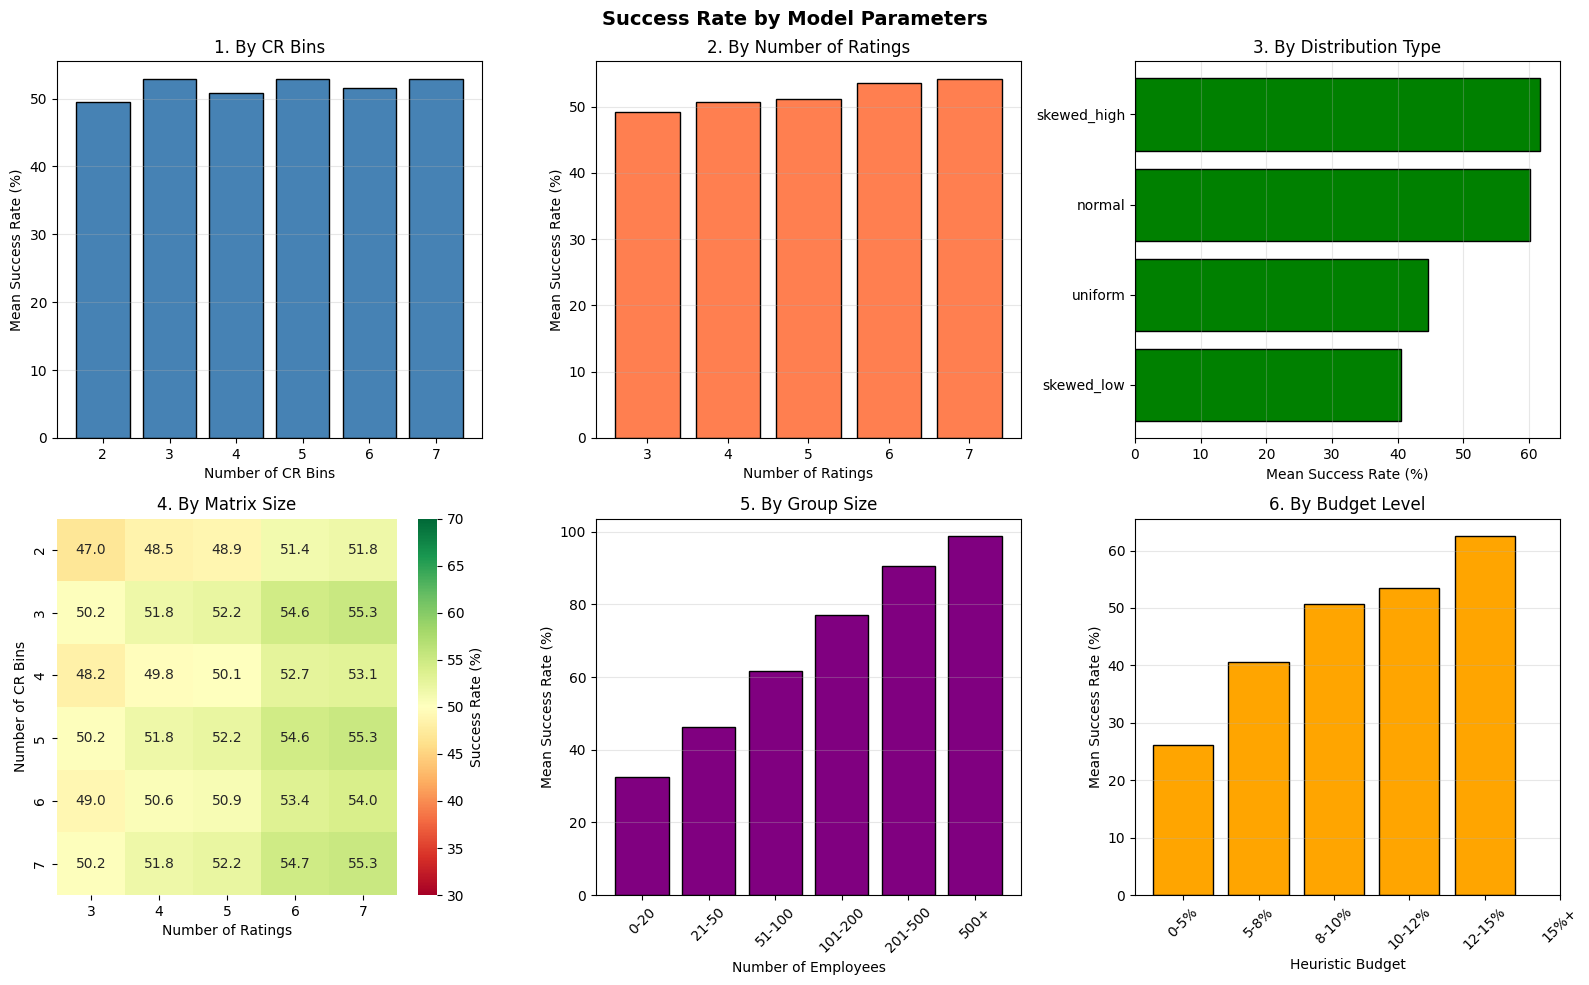

In [10]:
# ============================================================================
# VISUALIZE ALL FACTORS
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Success Rate by Model Parameters', fontsize=14, fontweight='bold')

# 1. By CR bins
cr_plot_data = df.groupby('n_cr_bins')['success_rate_pct'].mean()
axes[0,0].bar(cr_plot_data.index.astype(str), cr_plot_data.values, color='steelblue', edgecolor='black')
axes[0,0].set_xlabel('Number of CR Bins')
axes[0,0].set_ylabel('Mean Success Rate (%)')
axes[0,0].set_title('1. By CR Bins')
axes[0,0].grid(axis='y', alpha=0.3)

# 2. By ratings
rating_plot_data = df.groupby('n_ratings')['success_rate_pct'].mean()
axes[0,1].bar(rating_plot_data.index.astype(str), rating_plot_data.values, color='coral', edgecolor='black')
axes[0,1].set_xlabel('Number of Ratings')
axes[0,1].set_ylabel('Mean Success Rate (%)')
axes[0,1].set_title('2. By Number of Ratings')
axes[0,1].grid(axis='y', alpha=0.3)

# 3. By distribution
dist_plot_data = df.groupby('distribution_type')['success_rate_pct'].mean().sort_values()
axes[0,2].barh(range(len(dist_plot_data)), dist_plot_data.values, color='green', edgecolor='black')
axes[0,2].set_yticks(range(len(dist_plot_data)))
axes[0,2].set_yticklabels(dist_plot_data.index)
axes[0,2].set_xlabel('Mean Success Rate (%)')
axes[0,2].set_title('3. By Distribution Type')
axes[0,2].grid(axis='x', alpha=0.3)

# 4. Heatmap of matrix size
sns.heatmap(matrix_summary, annot=True, fmt='.1f', cmap='RdYlGn', center=50, 
            vmin=30, vmax=70, ax=axes[1,0], cbar_kws={'label': 'Success Rate (%)'})
axes[1,0].set_xlabel('Number of Ratings')
axes[1,0].set_ylabel('Number of CR Bins')
axes[1,0].set_title('4. By Matrix Size')

# 5. By group size
size_plot_data = df.groupby('size_bin')['success_rate_pct'].mean()
axes[1,1].bar(range(len(size_plot_data)), size_plot_data.values, color='purple', edgecolor='black')
axes[1,1].set_xticks(range(len(size_plot_data)))
axes[1,1].set_xticklabels(size_plot_data.index, rotation=45)
axes[1,1].set_xlabel('Number of Employees')
axes[1,1].set_ylabel('Mean Success Rate (%)')
axes[1,1].set_title('5. By Group Size')
axes[1,1].grid(axis='y', alpha=0.3)

# 6. By budget level
budget_plot_data = df.groupby('budget_bin')['success_rate_pct'].mean()
axes[1,2].bar(range(len(budget_plot_data)), budget_plot_data.values, color='orange', edgecolor='black')
axes[1,2].set_xticks(range(len(budget_plot_data)))
axes[1,2].set_xticklabels(budget_plot_data.index, rotation=45)
axes[1,2].set_xlabel('Heuristic Budget')
axes[1,2].set_ylabel('Mean Success Rate (%)')
axes[1,2].set_title('6. By Budget Level')
axes[1,2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Correlation Analysis - Model Parameters

**Цель:** Количественно оценить силу связи каждого параметра с success rate.

**Методология:**
- Pearson correlation coefficient (r) между каждым параметром и success_rate_pct
- P-value для проверки статистической значимости
- Encoding категориальных переменных как ordinal (порядковые)

**Интерпретация корреляции:**
- |r| > 0.7: Very Strong
- |r| > 0.4: Strong
- |r| > 0.2: Moderate
- |r| ≤ 0.2: Weak

**Ожидаемый результат:** Group size должен иметь самую сильную положительную корреляцию с success rate.

In [11]:
# ============================================================================
# CORRELATION ANALYSIS - MODEL PARAMETERS
# ============================================================================
print("\n" + "="*80)
print("CORRELATION ANALYSIS - MODEL PARAMETERS WITH SUCCESS RATE")
print("="*80)

from scipy.stats import pearsonr

# Encode categorical variables as ordinal
size_bin_encoding = {'0-20': 1, '21-50': 2, '51-100': 3, '101-200': 4, '201-500': 5, '500+': 6}
df['size_bin_encoded'] = df['size_bin'].map(size_bin_encoding)

budget_bin_encoding = {'0-5%': 1, '5-8%': 2, '8-10%': 3, '10-12%': 4, '12-15%': 5, '15%+': 6}
df['budget_bin_encoded'] = df['budget_bin'].map(budget_bin_encoding)

dist_encoding = {'skewed_low': 1, 'uniform': 2, 'normal': 3, 'skewed_high': 4}
df['distribution_encoded'] = df['distribution_type'].map(dist_encoding)

# Correlation analysis for all model parameters
model_params = {
    'CR Bins': 'n_cr_bins',
    'Ratings': 'n_ratings',
    'Distribution Type': 'distribution_encoded',
    'Group Size Bin': 'size_bin_encoded',
    'Budget Level Bin': 'budget_bin_encoded'
}

correlation_results = []
for param_name, param_col in model_params.items():
    r, p = pearsonr(df[param_col], df['success_rate_pct'])
    correlation_results.append({
        'Parameter': param_name,
        'Correlation (r)': round(r, 4),
        'P-value': f"{p:.2e}" if p < 0.001 else round(p, 4),
        'Strength': 'Very Strong' if abs(r) > 0.7 else 'Strong' if abs(r) > 0.4 else 'Moderate' if abs(r) > 0.2 else 'Weak'
    })

correlation_df = pd.DataFrame(correlation_results).sort_values('Correlation (r)', key=abs, ascending=False)
print(correlation_df.to_string(index=False))




CORRELATION ANALYSIS - MODEL PARAMETERS WITH SUCCESS RATE
        Parameter  Correlation (r)  P-value    Strength
   Group Size Bin           0.8613 0.00e+00 Very Strong
Distribution Type           0.3821 0.00e+00    Moderate
 Budget Level Bin           0.3270 0.00e+00    Moderate
          Ratings           0.0786 0.00e+00        Weak
          CR Bins           0.0313 1.55e-76        Weak


## Correlation Matrix - Full Picture

**Heatmap корреляций между всеми переменными:**

- Диагональ = 1.0 (переменная коррелирует с собой идеально)
- Положительные корреляции (красный) — переменные растут вместе
- Отрицательные корреляции (синий) — обратная связь
- Близко к 0 (белый) — нет линейной связи

**Цель:** Выявить:
1. Главный драйвер success rate
2. Потенциальные confounding variables (смешивающие факторы)
3. Мультиколлинеарность между предикторами


CORRELATION MATRIX - MODEL PARAMETERS
              Success Rate  CR Bins  Ratings  Distribution  Group Size  \
Success Rate         1.000    0.031    0.079         0.382       0.861   
CR Bins              0.031    1.000    0.000        -0.000      -0.000   
Ratings              0.079    0.000    1.000        -0.000       0.000   
Distribution         0.382   -0.000   -0.000         1.000      -0.000   
Group Size           0.861   -0.000    0.000        -0.000       1.000   
Budget Level         0.327    0.087   -0.002         0.906      -0.006   

              Budget Level  
Success Rate         0.327  
CR Bins              0.087  
Ratings             -0.002  
Distribution         0.906  
Group Size          -0.006  
Budget Level         1.000  


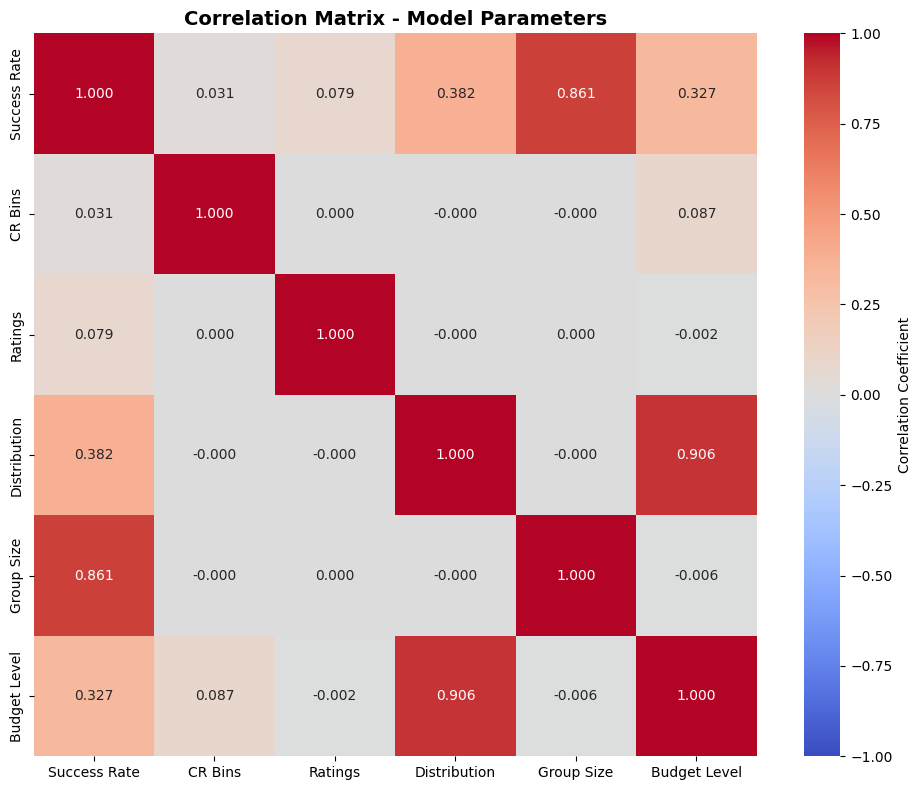

In [12]:
# Correlation matrix for model parameters
print("\n" + "="*80)
print("CORRELATION MATRIX - MODEL PARAMETERS")
print("="*80)

matrix_vars = ['success_rate_pct', 'n_cr_bins', 'n_ratings', 'distribution_encoded', 
               'size_bin_encoded', 'budget_bin_encoded']
corr_matrix = df[matrix_vars].corr().round(3)

# Rename for clarity
corr_matrix.index = ['Success Rate', 'CR Bins', 'Ratings', 'Distribution', 'Group Size', 'Budget Level']
corr_matrix.columns = ['Success Rate', 'CR Bins', 'Ratings', 'Distribution', 'Group Size', 'Budget Level']

print(corr_matrix)

# Visualize correlation matrix
fig_corr, ax_corr = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, ax=ax_corr, 
            cbar_kws={'label': 'Correlation Coefficient'})
ax_corr.set_title('Correlation Matrix - Model Parameters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Variation Analysis - Range of Effects

**Вопрос:** Какой фактор создает наибольший разброс в success rate?

**Методология:**
- Для каждого фактора: Range = Max Mean - Min Mean
- Чем больше Range → тем сильнее влияние фактора

**Интерпретация:**
- Фактор с максимальным Range — главная точка контроля для улучшения метода
- Факторы с минимальным Range — меньшая практическая значимость

**Использование:** Приоритизация инициатив по улучшению точности метода

In [13]:
# ============================================================================
# VARIATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("VARIATION ANALYSIS - RANGE OF SUCCESS RATES BY FACTOR")
print("="*80)

variation_summary = pd.DataFrame({
    'Factor': [
        'CR Bins',
        'Ratings', 
        'Distribution Type',
        'Group Size',
        'Budget Level'
    ],
    'Min Mean': [
        cr_summary['Mean'].min(),
        rating_summary['Mean'].min(),
        dist_summary['Mean'].min(),
        size_summary['Mean'].min(),
        budget_summary['Mean'].min()
    ],
    'Max Mean': [
        cr_summary['Mean'].max(),
        rating_summary['Mean'].max(),
        dist_summary['Mean'].max(),
        size_summary['Mean'].max(),
        budget_summary['Mean'].max()
    ]
})

variation_summary['Range'] = variation_summary['Max Mean'] - variation_summary['Min Mean']
variation_summary = variation_summary.sort_values('Range', ascending=False)
variation_summary = variation_summary.round(2)

print(variation_summary.to_string(index=False))


VARIATION ANALYSIS - RANGE OF SUCCESS RATES BY FACTOR
           Factor  Min Mean  Max Mean  Range
       Group Size     32.47     98.69  66.22
     Budget Level     26.08     62.45  36.37
Distribution Type     40.53     61.64  21.11
          Ratings     49.14     54.13   4.99
          CR Bins     49.52     52.84   3.32


## Group Size Threshold Analysis - Visual Exploration

**Ключевой вопрос:** Где находится порог, после которого success rate стабилизируется?

**Двухпанельная визуализация:**
1. **Linear scale:** Понимание абсолютных значений
2. **Log scale:** Выявление паттернов на малых размерах групп

**Красная линия (80% threshold):**
- Минимальный приемлемый уровень для бизнес-планирования
- Означает: 80% симуляций попали в бюджет ±5%

GROUP SIZE THRESHOLD ANALYSIS


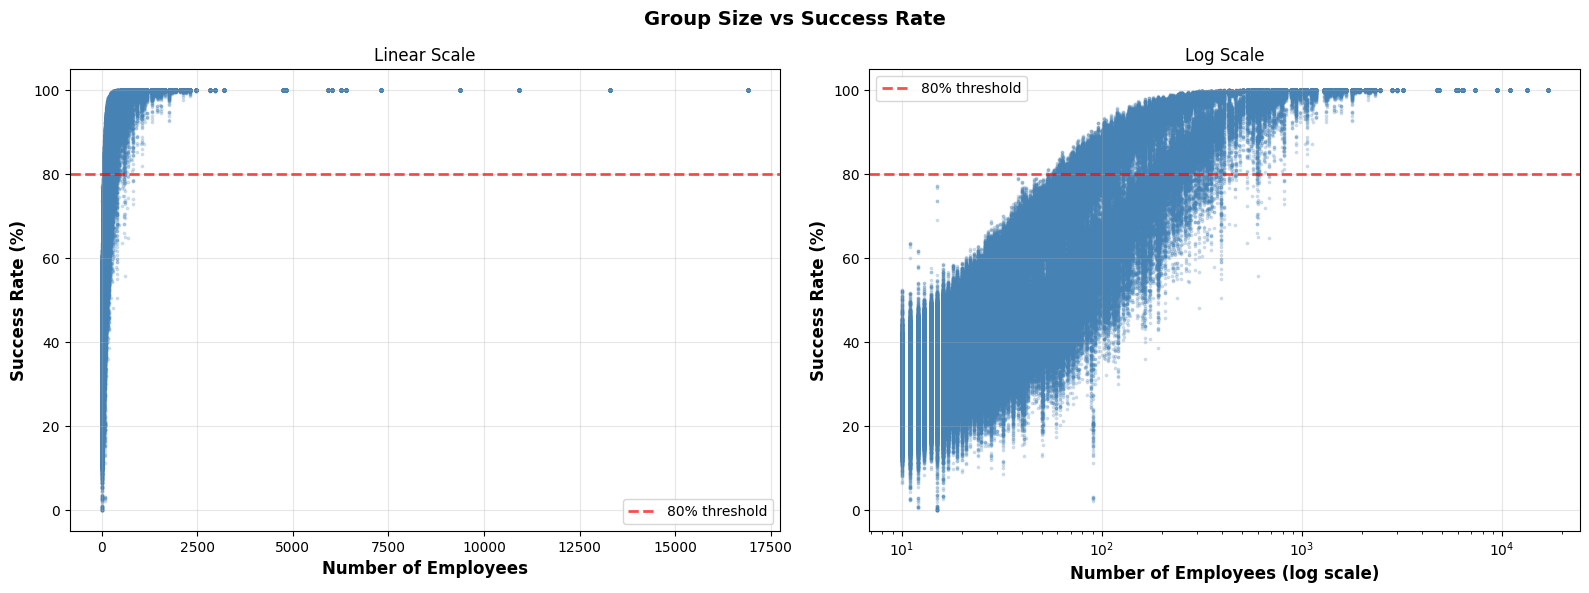

In [14]:
print("="*80)
print("GROUP SIZE THRESHOLD ANALYSIS")
print("="*80)

# ============================================================================
# VISUALIZE THE RELATIONSHIP
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Group Size vs Success Rate', fontsize=14, fontweight='bold')

# Linear scale
axes[0].scatter(df['n_employees'], df['success_rate_pct'], alpha=0.2, s=3, color='steelblue')
axes[0].axhline(80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='80% threshold')
axes[0].set_xlabel('Number of Employees', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Success Rate (%)', fontweight='bold', fontsize=12)
axes[0].set_title('Linear Scale', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].scatter(df['n_employees'], df['success_rate_pct'], alpha=0.2, s=3, color='steelblue')
axes[1].axhline(80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='80% threshold')
axes[1].set_xlabel('Number of Employees (log scale)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Success Rate (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Log Scale', fontsize=12)
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Systematic Threshold Testing - The Ladder

**Методология:** Тестируем множество порогов и сравниваем группы ниже/выше каждого порога.

**Тестируемые пороги:** 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 400, 500, 750, 1000

**Метрики для каждого порога:**
- **Below: Mean Success** — средний success rate для групп НИЖЕ порога
- **Above: Mean Success** — средний success rate для групп ВЫШЕ порога
- **Success Boost** — разница между Above и Below (эффект порога)

**Цель:** 
1. Найти пороги с максимальным Success Boost (самые важные "ступени")
2. Определить минимальный размер для достижения 80% и 90% success rate

## Key Findings - Critical Thresholds

**Top 5 thresholds с наибольшим Success Boost:**
- Эти пороги представляют критические точки перехода
- Показывают, где добавление сотрудников дает максимальный прирост точности

**Crossing 80% threshold:**
- Минимальный размер группы для достижения среднего success rate ≥80%
- Практический минимум для использования метода в бизнес-планировании

**Crossing 90% threshold:**
- Размер группы для "high confidence" применения
- Рекомендуемый минимум для критически важных расчетов

## Detailed Ladder - Success Rate by Size Ranges

**Детальная сегментация:** Разбивка на более узкие диапазоны размеров групп.

**Метрики по каждому диапазону:**
- **N Groups** — количество групп в диапазоне
- **Mean Success** — средний success rate
- **Median Success** — медиана (robust к выбросам)
- **Mean Variance** — средняя вариативность Monte Carlo результатов

**Интерпретация Mean Variance:**
- Низкая variance → стабильные предсказания → высокая надежность
- Высокая variance → непредсказуемость → низкая надежность

In [15]:
# ============================================================================
# IDENTIFY KEY THRESHOLDS
# ============================================================================
print("\n" + "="*80)
print("THRESHOLD ANALYSIS - FINDING THE LADDER")
print("="*80)

# Test various thresholds
thresholds = [20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 400, 500, 750, 1000]

threshold_results = []
for threshold in thresholds:
    below = df[df['n_employees'] < threshold]
    above = df[df['n_employees'] >= threshold]
    
    if len(below) > 0 and len(above) > 0:
        threshold_results.append({
            'Threshold': threshold,
            'Below: N Groups': len(below),
            'Below: Mean Success': round(below['success_rate_pct'].mean(), 2),
            'Above: N Groups': len(above),
            'Above: Mean Success': round(above['success_rate_pct'].mean(), 2),
            'Success Boost': round(above['success_rate_pct'].mean() - below['success_rate_pct'].mean(), 2)
        })

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df.to_string(index=False))

# ============================================================================
# IDENTIFY OPTIMAL THRESHOLDS
# ============================================================================
print("\n" + "="*80)
print("KEY FINDINGS - WHERE ARE THE SUBSTANTIAL JUMPS?")
print("="*80)

# Find thresholds with biggest jumps
biggest_jumps = threshold_df.nlargest(5, 'Success Boost')
print("\nTop 5 thresholds with biggest success boost:")
print(biggest_jumps[['Threshold', 'Below: Mean Success', 'Above: Mean Success', 'Success Boost']].to_string(index=False))

# Find threshold where we cross 80% success
above_80_thresholds = threshold_df[threshold_df['Above: Mean Success'] >= 80]
if len(above_80_thresholds) > 0:
    min_threshold_80 = above_80_thresholds['Threshold'].min()
    print(f"\nMinimum group size to achieve 80%+ mean success rate: {min_threshold_80} employees")
    
    row_80 = threshold_df[threshold_df['Threshold'] == min_threshold_80].iloc[0]
    print(f"  Groups ≥{min_threshold_80}: {row_80['Above: N Groups']} groups, {row_80['Above: Mean Success']:.2f}% success")
    print(f"  Groups <{min_threshold_80}: {row_80['Below: N Groups']} groups, {row_80['Below: Mean Success']:.2f}% success")

# Find threshold where we cross 90% success
above_90_thresholds = threshold_df[threshold_df['Above: Mean Success'] >= 90]
if len(above_90_thresholds) > 0:
    min_threshold_90 = above_90_thresholds['Threshold'].min()
    print(f"\nMinimum group size to achieve 90%+ mean success rate: {min_threshold_90} employees")
    
    row_90 = threshold_df[threshold_df['Threshold'] == min_threshold_90].iloc[0]
    print(f"  Groups ≥{min_threshold_90}: {row_90['Above: N Groups']} groups, {row_90['Above: Mean Success']:.2f}% success")
    print(f"  Groups <{min_threshold_90}: {row_90['Below: N Groups']} groups, {row_90['Below: Mean Success']:.2f}% success")

# ============================================================================
# ROLLING AVERAGE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("DETAILED LADDER - SUCCESS RATE BY EXACT GROUP SIZE")
print("="*80)

# Calculate mean success rate for ranges
ranges = [
    (10, 20), (20, 30), (30, 40), (40, 50), (50, 75), 
    (75, 100), (100, 150), (150, 200), (200, 300), (300, 500), (500, 1000), (1000, 20000)
]

ladder_results = []
for min_size, max_size in ranges:
    subset = df[(df['n_employees'] >= min_size) & (df['n_employees'] < max_size)]
    if len(subset) > 0:
        ladder_results.append({
            'Size Range': f'{min_size}-{max_size-1}',
            'N Groups': len(subset),
            'Mean Success': round(subset['success_rate_pct'].mean(), 2),
            'Median Success': round(subset['success_rate_pct'].median(), 2),
            'Mean Variance': round(subset['mc_std_pct'].mean(), 3)
        })

ladder_df = pd.DataFrame(ladder_results)
print(ladder_df.to_string(index=False))

# ============================================================================
# RECOMMENDED THRESHOLDS
# ============================================================================
print("\n" + "="*80)
print("RECOMMENDED GROUP SIZE THRESHOLDS")
print("="*80)

recommendations = []

for threshold in [50, 100, 150, 200]:
    subset = df[df['n_employees'] >= threshold]
    pct_above_80 = (subset['success_rate_pct'] >= 80).mean() * 100
    
    recommendations.append({
        'Minimum Size': f'≥{threshold}',
        'N Groups': len(subset),
        'Pct of Total': f"{len(subset)/len(df)*100:.1f}%",
        'Mean Success': round(subset['success_rate_pct'].mean(), 2),
        'Groups ≥80%': f"{pct_above_80:.1f}%"
    })

rec_df = pd.DataFrame(recommendations)
print(rec_df.to_string(index=False))

print("\n" + "="*80)


THRESHOLD ANALYSIS - FINDING THE LADDER
 Threshold  Below: N Groups  Below: Mean Success  Above: N Groups  Above: Mean Success  Success Boost
        20           113520                32.12           237000                61.12          29.00
        30           169680                35.13           180840                67.30          32.17
        40           201600                37.12           148920                71.50          34.38
        50           223200                38.66           127320                74.63          35.97
        75           263400                41.75            87120                81.88          40.12
       100           280680                43.30            69840                85.60          42.30
       125           294480                44.67            56040                88.82          44.16
       150           302160                45.51            48360                90.59          45.08
       175           308520              

## Sophisticated Threshold Detection - Academic Approach

**Переход к продвинутым методам:**
До этого момента использовали простые пороги. Теперь применяем академические методы для более точного определения точек перехода.

**Piecewise Linear Regression:**
- Моделируем relationship между group size и success rate как несколько линейных сегментов
- Автоматически находим оптимальные breakpoints (точки излома)
- Учитываем constraint: минимум 1000 групп в каждом сегменте (для статистической значимости)

**Преимущества:**
- Объективное определение точек перехода (не arbitrary)
- Учитывает нелинейность relationship
- Позволяет количественно оценить slope (скорость роста) в каждом сегменте


## Model Selection - AICc (Akaike Information Criterion corrected)

**Вопрос:** Сколько сегментов (breakpoints) оптимально для модели?

**AICc балансирует:**
- **Goodness of fit** (качество подгонки) — чем меньше MSE, тем лучше
- **Model complexity** (сложность модели) — чем больше параметров, тем хуже (риск overfitting)

**Формула AICc:**
```
AIC = n × log(MSE) + 2k
AICc = AIC + (2k(k+1)) / (n - k - 1)  # correction для конечных выборок
```
где k = количество параметров, n = размер выборки

**Выбор модели:** Минимальный AICc = оптимальный баланс точности и простоты

**Проверка монотонности:** Success rate должен расти (или оставаться стабильным) с увеличением group size — не должно быть снижения.


## Local Analysis at Breakpoints - Gaussian Weighting

**Цель:** Детальный анализ success rate в окрестности каждого breakpoint с оценкой uncertainty.

**Методология:**
- **Gaussian weighting:** Точки ближе к breakpoint получают больший вес
- **Bootstrap confidence intervals:** 1000 resamples для оценки 95% CI
- **Window:** Адаптивный размер окна (1% от данных или 30-200 групп)

**Интерпретация:**
- **Local Mean** — локальный средний success rate в окрестности breakpoint
- **95% CI** — диапазон uncertainty (узкий CI = высокая уверенность)

**Практическое применение:** Понимание локального поведения модели в критических точках


## Robust Threshold Detection Methods - Multiple Approaches

**Философия:** Один метод может ошибаться. Используем 4 независимых подхода и сравниваем результаты.

**4 метода определения порога 80% success:**

**1. Raw First-Hit:**
- Первая группа, достигшая ≥80% success rate
- Простой, но sensitive к выбросам

**2. Smoothed First-Hit:**
- Rolling mean (скользящее среднее) сглаживает шум
- Более robust к локальным флуктуациям

**3. Quantile-Based:**
- Ищем порог, где P50/P60/P70 ≥80%
- Гарантирует, что большинство/60%/70% групп успешны

**4. Piecewise Model Crossing:**
- Где fitted модель пересекает 80%
- Использует всю информацию, а не только raw data

**Консенсус:** Если все методы дают похожие результаты → высокая уверенность в пороге


## Optimal Segmentation Summary Table

**Comprehensive view всех сегментов:**

Для каждого сегмента показываем:
- **Breakpoint** — идентификатор сегмента (BP1, BP2, ...)
- **Employees ≈** — диапазон размеров групп в сегменте
- **N Groups** — количество групп
- **Mean/Median** — центральные тенденции
- **Min/Max** — диапазон наблюдаемых значений

**Паттерн прогрессии:**
- BP1 (малые группы): Низкий Mean, высокая вариативность
- BP2-BP3 (средние): Рост Mean, снижение вариативности
- BP4+ (крупные): Высокий Mean, стабильные результаты

**Использование:** Определение risk profile для разных размеров групп

In [16]:
print("="*80)
print("THRESHOLD DETECTION - ACADEMIC APPROACH")
print("="*80)

df_sorted = df.sort_values('n_employees').reset_index(drop=True)

# ============================================================================
# PIECEWISE LINEAR REGRESSION WITH ACADEMIC ENHANCEMENTS
# ============================================================================

def piecewise_linear(x, x_breakpoints, slopes, intercepts):
    """Calculate y values for piecewise linear function."""
    y = np.zeros_like(x, dtype=float)
    
    mask = x < x_breakpoints[0]
    y[mask] = slopes[0] * x[mask] + intercepts[0]
    
    for i in range(len(x_breakpoints) - 1):
        mask = (x >= x_breakpoints[i]) & (x < x_breakpoints[i + 1])
        y[mask] = slopes[i + 1] * x[mask] + intercepts[i + 1]
    
    mask = x >= x_breakpoints[-1]
    y[mask] = slopes[-1] * x[mask] + intercepts[-1]
    
    return y

def fit_piecewise_linear(x, y, n_segments, min_segment_size=1000):
    """Fit piecewise linear regression with minimum segment size constraint."""
    percentiles = np.linspace(100/n_segments, 100*(n_segments-1)/n_segments, n_segments-1)
    initial_breakpoints = np.percentile(x, percentiles)
    
    def objective(breakpoints):
        breakpoints = np.sort(breakpoints)
        
        # Check minimum segment size constraint
        segment_sizes = []
        segment_sizes.append(np.sum(x < breakpoints[0]))
        for i in range(len(breakpoints) - 1):
            segment_sizes.append(np.sum((x >= breakpoints[i]) & (x < breakpoints[i + 1])))
        segment_sizes.append(np.sum(x >= breakpoints[-1]))
        
        if any(s < min_segment_size for s in segment_sizes):
            return 1e10  # Penalty for violating constraint
        
        slopes = []
        intercepts = []
        
        mask = x < breakpoints[0]
        if mask.sum() > 1:
            x_seg = x[mask]
            y_seg = y[mask]
            # Normalize x for better numerical stability
            x_mean, x_std = x_seg.mean(), x_seg.std()
            if x_std > 0:
                x_norm = (x_seg - x_mean) / x_std
                slope_norm, intercept_norm = np.polyfit(x_norm, y_seg, 1)
                slope = slope_norm / x_std
                intercept = intercept_norm - slope_norm * x_mean / x_std
            else:
                slope = 0
                intercept = y_seg.mean()
        else:
            slope, intercept = 0, y.mean()
        slopes.append(slope)
        intercepts.append(intercept)
        
        for i in range(len(breakpoints) - 1):
            mask = (x >= breakpoints[i]) & (x < breakpoints[i + 1])
            if mask.sum() > 1:
                x_seg = x[mask]
                y_seg = y[mask]
                x_mean, x_std = x_seg.mean(), x_seg.std()
                if x_std > 0:
                    x_norm = (x_seg - x_mean) / x_std
                    slope_norm, intercept_norm = np.polyfit(x_norm, y_seg, 1)
                    slope = slope_norm / x_std
                    intercept = intercept_norm - slope_norm * x_mean / x_std
                else:
                    slope = 0
                    intercept = y_seg.mean()
            else:
                slope, intercept = slopes[-1], intercepts[-1]
            slopes.append(slope)
            intercepts.append(intercept)
        
        mask = x >= breakpoints[-1]
        if mask.sum() > 1:
            x_seg = x[mask]
            y_seg = y[mask]
            x_mean, x_std = x_seg.mean(), x_seg.std()
            if x_std > 0:
                x_norm = (x_seg - x_mean) / x_std
                slope_norm, intercept_norm = np.polyfit(x_norm, y_seg, 1)
                slope = slope_norm / x_std
                intercept = intercept_norm - slope_norm * x_mean / x_std
            else:
                slope = 0
                intercept = y_seg.mean()
        else:
            slope, intercept = slopes[-1], intercepts[-1]
        slopes.append(slope)
        intercepts.append(intercept)
        
        y_pred = piecewise_linear(x, breakpoints, slopes, intercepts)
        return mean_squared_error(y, y_pred)
    
    bounds = [(x.min(), x.max()) for _ in range(n_segments - 1)]
    result = minimize(objective, initial_breakpoints, bounds=bounds, method='L-BFGS-B')
    
    optimal_breakpoints = np.sort(result.x)
    
    # Refit with optimal breakpoints
    slopes = []
    intercepts = []
    
    mask = x < optimal_breakpoints[0]
    if mask.sum() > 1:
        x_seg = x[mask]
        y_seg = y[mask]
        x_mean, x_std = x_seg.mean(), x_seg.std()
        if x_std > 0:
            x_norm = (x_seg - x_mean) / x_std
            slope_norm, intercept_norm = np.polyfit(x_norm, y_seg, 1)
            slope = slope_norm / x_std
            intercept = intercept_norm - slope_norm * x_mean / x_std
        else:
            slope = 0
            intercept = y_seg.mean()
    else:
        slope, intercept = 0, y.mean()
    slopes.append(slope)
    intercepts.append(intercept)
    
    for i in range(len(optimal_breakpoints) - 1):
        mask = (x >= optimal_breakpoints[i]) & (x < optimal_breakpoints[i + 1])
        if mask.sum() > 1:
            x_seg = x[mask]
            y_seg = y[mask]
            x_mean, x_std = x_seg.mean(), x_seg.std()
            if x_std > 0:
                x_norm = (x_seg - x_mean) / x_std
                slope_norm, intercept_norm = np.polyfit(x_norm, y_seg, 1)
                slope = slope_norm / x_std
                intercept = intercept_norm - slope_norm * x_mean / x_std
            else:
                slope = 0
                intercept = y_seg.mean()
        else:
            slope, intercept = slopes[-1], intercepts[-1]
        slopes.append(slope)
        intercepts.append(intercept)
    
    mask = x >= optimal_breakpoints[-1]
    if mask.sum() > 1:
        x_seg = x[mask]
        y_seg = y[mask]
        x_mean, x_std = x_seg.mean(), x_seg.std()
        if x_std > 0:
            x_norm = (x_seg - x_mean) / x_std
            slope_norm, intercept_norm = np.polyfit(x_norm, y_seg, 1)
            slope = slope_norm / x_std
            intercept = intercept_norm - slope_norm * x_mean / x_std
        else:
            slope = 0
            intercept = y_seg.mean()
    else:
        slope, intercept = slopes[-1], intercepts[-1]
    slopes.append(slope)
    intercepts.append(intercept)
    
    return optimal_breakpoints, slopes, intercepts, result.fun

x = df_sorted['n_employees'].values
y = df_sorted['success_rate_pct'].values

# Find optimal number of segments using AICc
print("\n" + "="*80)
print("MODEL SELECTION - AICc (corrected for finite sample size)")
print("="*80)

n_segments_range = range(2, 8)
results_segments = []

for n_seg in n_segments_range:
    breakpoints, slopes, intercepts, mse = fit_piecewise_linear(x, y, n_seg, min_segment_size=1000)
    
    k = 2 * n_seg  # parameters (slopes + intercepts)
    n = len(x)
    
    # AIC and AICc
    aic = n * np.log(mse) + 2 * k
    if n - k - 1 > 0:
        aicc = aic + (2 * k * (k + 1)) / (n - k - 1)
    else:
        aicc = np.inf
    
    results_segments.append({
        'N Segments': n_seg,
        'Parameters (k)': k,
        'MSE': round(mse, 4),
        'AIC': round(aic, 2),
        'AICc': round(aicc, 2)
    })

results_seg_df = pd.DataFrame(results_segments)
print("\n", results_seg_df.to_string(index=False))

optimal_n_seg = results_seg_df.loc[results_seg_df['AICc'].idxmin(), 'N Segments']
print(f"\nOptimal number of segments (min AICc): {optimal_n_seg}")

# Fit with optimal number of segments
breakpoints_opt, slopes_opt, intercepts_opt, _ = fit_piecewise_linear(x, y, optimal_n_seg, min_segment_size=1000)

# Check monotonicity
y_pred_all = piecewise_linear(x, breakpoints_opt, slopes_opt, intercepts_opt)
is_monotone = np.all(np.diff(y_pred_all) >= -1e-6)
print(f"Piecewise prediction is monotone (non-decreasing): {is_monotone}")

# ============================================================================
# LOCAL ANALYSIS AT EACH BREAKPOINT
# ============================================================================
print("\n" + "="*80)
print("LOCAL ANALYSIS AT BREAKPOINTS (Gaussian-weighted)")
print("="*80)

def local_mean_bootstrap_ci(x_all, y_all, x0, window_pct=0.01, n_bootstrap=1000):
    """Calculate local mean with bootstrap 95% CI using Gaussian weighting."""
    # Define window
    window_size = max(30, min(200, int(len(x_all) * window_pct)))
    
    # Get points near x0
    distances = np.abs(x_all - x0)
    idx = np.argsort(distances)[:window_size]
    
    x_local = x_all[idx]
    y_local = y_all[idx]
    
    # Gaussian weights
    sigma = np.std(x_local - x0)
    if sigma < 1:
        sigma = 1
    weights = np.exp(-((x_local - x0)**2) / (2 * sigma**2))
    weights = weights / weights.sum()
    
    # Weighted mean
    local_mean = np.sum(weights * y_local)
    
    # Bootstrap CI
    bootstrap_means = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(y_local), size=len(y_local), replace=True)
        boot_weights = weights[indices]
        boot_weights = boot_weights / boot_weights.sum()
        bootstrap_means.append(np.sum(boot_weights * y_local[indices]))
    
    ci_lower = np.percentile(bootstrap_means, 2.5)
    ci_upper = np.percentile(bootstrap_means, 97.5)
    
    return local_mean, ci_lower, ci_upper

print("\nBreakpoint | Employees | Local Mean | 95% CI")
print("-" * 60)

for i, bp in enumerate(breakpoints_opt):
    local_mean, ci_low, ci_high = local_mean_bootstrap_ci(x, y, bp)
    print(f"BP{i+2:>2}       | {int(bp):>9} | {local_mean:>9.2f}% | [{ci_low:.2f}%, {ci_high:.2f}%]")

# ============================================================================
# ROBUST THRESHOLD VARIANTS
# ============================================================================
print("\n" + "="*80)
print("ROBUST THRESHOLD DETECTION METHODS")
print("="*80)

# Method 1: Raw first-hit
raw_first_hit = df_sorted[df_sorted['success_rate_pct'] >= 80]['n_employees'].min()
print(f"\n1. Raw First-Hit (first group ≥80%):")
print(f"   {raw_first_hit} employees")

# Method 2: Smoothed first-hit (rolling mean)
window_size = max(100, int(len(df_sorted) * 0.01))
df_sorted['rolling_mean'] = df_sorted['success_rate_pct'].rolling(window=window_size, center=True).mean()
smoothed_first_hit = df_sorted[df_sorted['rolling_mean'] >= 80]['n_employees'].min()
print(f"\n2. Smoothed First-Hit (rolling mean ≥80%, window={window_size}):")
print(f"   {smoothed_first_hit} employees")

# Method 3: Quantile targets
quantiles_to_test = [0.50, 0.60, 0.70]
print(f"\n3. Quantile-Based Thresholds:")

for q in quantiles_to_test:
    # For each threshold, find where quantile >= 80%
    thresholds_test = [50, 75, 100, 125, 150, 175, 200, 250]
    for threshold in thresholds_test:
        subset = df[df['n_employees'] >= threshold]
        if len(subset) > 0:
            quantile_val = subset['success_rate_pct'].quantile(q)
            if quantile_val >= 80:
                print(f"   P{int(q*100)} ≥80%: {threshold} employees (P{int(q*100)}={quantile_val:.1f}%)")
                break

# Method 4: Piecewise model crossing
crossing_idx = np.where(np.diff(y_pred_all >= 80))[0]
if len(crossing_idx) > 0:
    crossing_point = x[crossing_idx[0]]
    print(f"\n4. Piecewise Model Crossing:")
    print(f"   {int(crossing_point)} employees")

# ============================================================================
# SEGMENT SUMMARY TABLE
# ============================================================================
print("\n" + "="*80)
print(f"OPTIMAL SEGMENTATION: {optimal_n_seg} segments")
print("="*80)

segment_data = []

mask = df['n_employees'] < breakpoints_opt[0]
segment_df = df[mask]
segment_data.append({
    'Breakpoint': 'BP1',
    'Employees ≈': f"<{int(breakpoints_opt[0])}",
    'N Groups': len(segment_df),
    'Mean': f"{segment_df['success_rate_pct'].mean():.1f}%",
    'Median': f"{segment_df['success_rate_pct'].median():.1f}%",
    'Min': f"{segment_df['success_rate_pct'].min():.0f}%",
    'Max': f"{segment_df['success_rate_pct'].max():.0f}%"
})

for i in range(len(breakpoints_opt) - 1):
    mask = (df['n_employees'] >= breakpoints_opt[i]) & (df['n_employees'] < breakpoints_opt[i+1])
    segment_df = df[mask]
    segment_data.append({
        'Breakpoint': f'BP{i+2}',
        'Employees ≈': int(breakpoints_opt[i]),
        'N Groups': len(segment_df),
        'Mean': f"{segment_df['success_rate_pct'].mean():.1f}%",
        'Median': f"{segment_df['success_rate_pct'].median():.1f}%",
        'Min': f"{segment_df['success_rate_pct'].min():.0f}%",
        'Max': f"{segment_df['success_rate_pct'].max():.0f}%"
    })

mask = df['n_employees'] >= breakpoints_opt[-1]
segment_df = df[mask]
segment_data.append({
    'Breakpoint': f'BP{len(breakpoints_opt)+1}',
    'Employees ≈': int(breakpoints_opt[-1]),
    'N Groups': len(segment_df),
    'Mean': f"{segment_df['success_rate_pct'].mean():.1f}%",
    'Median': f"{segment_df['success_rate_pct'].median():.1f}%",
    'Min': f"{segment_df['success_rate_pct'].min():.0f}%",
    'Max': f"{segment_df['success_rate_pct'].max():.0f}%"
})

segment_summary = pd.DataFrame(segment_data)
print("\n", segment_summary.to_string(index=False))

SOPHISTICATED THRESHOLD DETECTION - ACADEMIC APPROACH

MODEL SELECTION - AICc (corrected for finite sample size)

  N Segments  Parameters (k)      MSE        AIC       AICc
          2               4 232.6256 1910142.33 1910142.33
          3               6 172.1843 1804687.15 1804687.15
          4               8 147.0757 1749442.88 1749442.88
          5              10 135.2899 1720168.94 1720168.94
          6              12 128.8981 1703208.58 1703208.59
          7              14 125.9135 1695000.82 1695000.82

Optimal number of segments (min AICc): 7
Piecewise prediction is monotone (non-decreasing): True

LOCAL ANALYSIS AT BREAKPOINTS (Gaussian-weighted)

Breakpoint | Employees | Local Mean | 95% CI
------------------------------------------------------------
BP 2       |        12 |     33.52% | [32.38%, 34.67%]
BP 3       |        17 |     33.19% | [31.89%, 34.58%]
BP 4       |        25 |     43.14% | [41.75%, 44.60%]
BP 5       |        39 |     50.84% | [49.16%, 52.5

## Advanced Visualizations

**4-панельная визуализация piecewise regression:**

**Panel 1: Detail View (0-2500 employees)**
- Scatter plot с наложенной piecewise fit
- Вертикальные линии показывают breakpoints
- Фокус на критическом диапазоне (где большинство групп)
- Y-axis ограничен 105% (убираем выбросы для лучшей читаемости)

**Panel 2: Log Scale (Full Range)**
- Та же модель, но x-axis в логарифмическом масштабе
- Позволяет видеть паттерны на малых группах
- Показывает весь диапазон данных

**Panel 3: Heatmap - Success Rate Distribution**
- 2D распределение: Employee Range × Success Rate bins
- Цвет = % групп в каждой ячейке
- Показывает, где концентрируются данные
- Выявляет potential multimodality (несколько пиков)

**Panel 4: Success by Segment (Mean & Median)**
- Bar chart с mean success rate по сегментам
- Цвет кодирует performance: Red (<60%), Orange (60-80%), Green (≥80%)
- Median внутри bars для проверки robustness
- Горизонтальная линия показывает 80% target

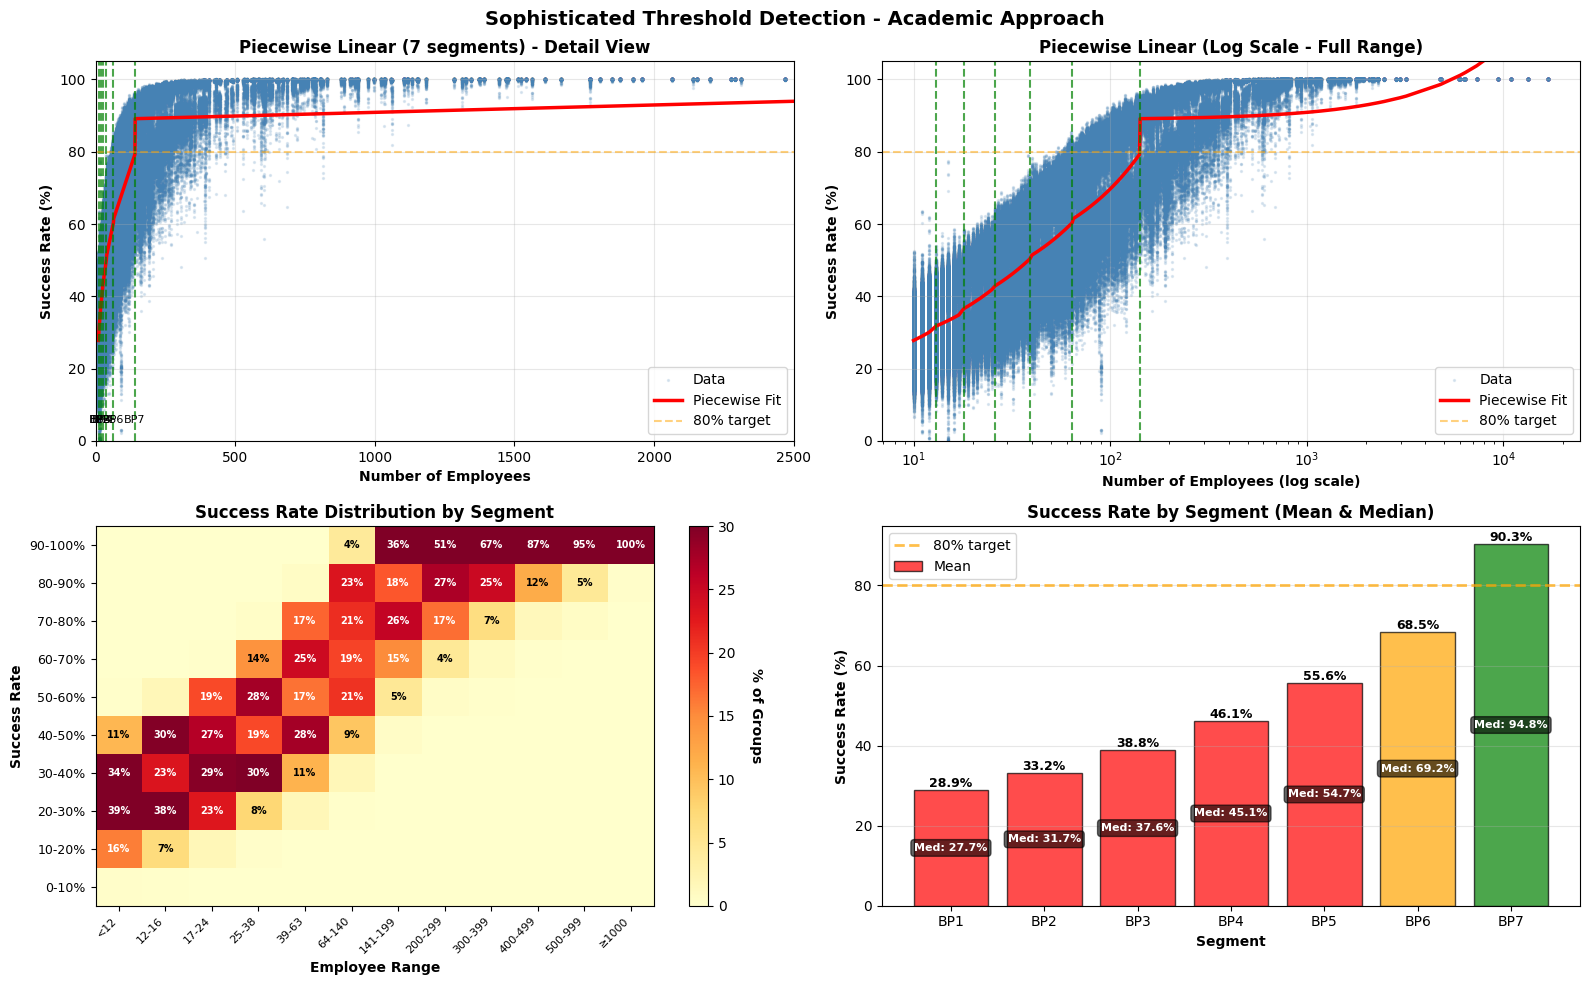


ANALYSIS COMPLETE


In [17]:
# ============================================================================
# IMPROVED VISUALIZATIONS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Sophisticated Threshold Detection - Academic Approach', fontsize=14, fontweight='bold')

x_plot = df_sorted['n_employees'].values
y_plot = df_sorted['success_rate_pct'].values

# 1. Piecewise fit - linear scale (ZOOMED TO 2500)
axes[0,0].scatter(x_plot, y_plot, alpha=0.15, s=2, color='steelblue', label='Data')
axes[0,0].plot(x_plot, y_pred_all, 'r-', linewidth=2.5, label='Piecewise Fit')
for i, bp in enumerate(breakpoints_opt):
    if bp <= 2500:  # Only show breakpoints within range
        axes[0,0].axvline(bp, color='green', linestyle='--', alpha=0.7, linewidth=1.5)
        axes[0,0].text(bp, 5, f'BP{i+2}', rotation=0, fontsize=8, ha='center')
axes[0,0].axhline(80, color='orange', linestyle='--', alpha=0.5, linewidth=1.5, label='80% target')
axes[0,0].set_xlabel('Number of Employees', fontweight='bold')
axes[0,0].set_ylabel('Success Rate (%)', fontweight='bold')
axes[0,0].set_title(f'Piecewise Linear ({optimal_n_seg} segments) - Detail View', fontweight='bold')
axes[0,0].set_xlim(0, 2500)  # LIMIT TO 2500
axes[0,0].set_ylim(0, 105)  # LIMIT Y-AXIS TO 105%
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Piecewise fit - log scale
axes[0,1].scatter(x_plot, y_plot, alpha=0.15, s=2, color='steelblue', label='Data')
axes[0,1].plot(x_plot, y_pred_all, 'r-', linewidth=2.5, label='Piecewise Fit')
for i, bp in enumerate(breakpoints_opt):
    axes[0,1].axvline(bp, color='green', linestyle='--', alpha=0.7, linewidth=1.5)
axes[0,1].axhline(80, color='orange', linestyle='--', alpha=0.5, linewidth=1.5, label='80% target')
axes[0,1].set_xlabel('Number of Employees (log scale)', fontweight='bold')
axes[0,1].set_ylabel('Success Rate (%)', fontweight='bold')
axes[0,1].set_title('Piecewise Linear (Log Scale - Full Range)', fontweight='bold')
axes[0,1].set_xscale('log')
axes[0,1].set_ylim(0, 105)  # LIMIT Y-AXIS TO 105%
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. HEATMAP: Success Rate Distribution by Employee Segment
# Create success rate bins
success_rate_bins = np.arange(0, 101, 10)  # 0-10, 10-20, ..., 90-100
bin_labels = [f'{i}-{i+10}%' for i in range(0, 100, 10)]

# Create segment ranges based on breakpoints + additional ranges
segment_ranges = []
segment_range_labels = []

# First segment
segment_ranges.append((0, breakpoints_opt[0]))
segment_range_labels.append(f'<{int(breakpoints_opt[0])}')

# Middle segments (up to the last breakpoint before 141)
for i in range(len(breakpoints_opt) - 1):
    segment_ranges.append((breakpoints_opt[i], breakpoints_opt[i+1]))
    segment_range_labels.append(f'{int(breakpoints_opt[i])}-{int(breakpoints_opt[i+1])-1}')

# Last breakpoint segment (up to 200)
segment_ranges.append((breakpoints_opt[-1], 200))
segment_range_labels.append(f'{int(breakpoints_opt[-1])}-199')

# Additional granular segments
segment_ranges.append((200, 300))
segment_range_labels.append('200-299')

segment_ranges.append((300, 400))
segment_range_labels.append('300-399')

segment_ranges.append((400, 500))
segment_range_labels.append('400-499')

segment_ranges.append((500, 1000))
segment_range_labels.append('500-999')

segment_ranges.append((1000, np.inf))
segment_range_labels.append('≥1000')

# Create heatmap matrix
heatmap_data = np.zeros((len(bin_labels), len(segment_ranges)))

for seg_idx, (low, high) in enumerate(segment_ranges):
    # Get data for this segment
    mask = (df['n_employees'] >= low) & (df['n_employees'] < high)
    segment_success_rates = df[mask]['success_rate_pct'].values
    
    # Count how many groups fall into each success rate bin
    for bin_idx in range(len(bin_labels)):
        bin_low = success_rate_bins[bin_idx]
        bin_high = success_rate_bins[bin_idx + 1]
        count = np.sum((segment_success_rates >= bin_low) & (segment_success_rates < bin_high))
        heatmap_data[bin_idx, seg_idx] = count

# Normalize by column (to show percentage within each segment)
# Handle columns with zero total
column_sums = heatmap_data.sum(axis=0)
heatmap_pct = np.zeros_like(heatmap_data)
for col in range(heatmap_data.shape[1]):
    if column_sums[col] > 0:
        heatmap_pct[:, col] = heatmap_data[:, col] / column_sums[col] * 100

# Create heatmap
im = axes[1,0].imshow(heatmap_pct[::-1], cmap='YlOrRd', aspect='auto', vmin=0, vmax=30)

# Set ticks and labels
axes[1,0].set_xticks(range(len(segment_range_labels)))
axes[1,0].set_xticklabels(segment_range_labels, rotation=45, ha='right', fontsize=8)
axes[1,0].set_yticks(range(len(bin_labels)))
axes[1,0].set_yticklabels(bin_labels[::-1], fontsize=9)

axes[1,0].set_xlabel('Employee Range', fontweight='bold')
axes[1,0].set_ylabel('Success Rate', fontweight='bold')
axes[1,0].set_title('Success Rate Distribution by Segment', fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1,0])
cbar.set_label('% of Groups', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations - adjust color based on background
for i in range(len(bin_labels)):
    for j in range(len(segment_range_labels)):
        value = heatmap_pct[len(bin_labels)-1-i, j]
        if value > 2:  # Only show if > 2% to avoid clutter
            # Choose text color based on background intensity
            text_color = 'white' if value > 15 else 'black'
            text = axes[1,0].text(j, i, f'{value:.0f}%',
                                ha="center", va="center", color=text_color, 
                                fontsize=7, fontweight='bold')

# 4. Success rate by segment with mean and median
segment_means = []
segment_medians = []
segment_labels = []
for i, row in segment_summary.iterrows():
    mean_val = float(row['Mean'].replace('%', ''))
    median_val = float(row['Median'].replace('%', ''))
    segment_means.append(mean_val)
    segment_medians.append(median_val)
    segment_labels.append(row['Breakpoint'])

colors = ['red' if x < 60 else 'orange' if x < 80 else 'green' for x in segment_means]
bars = axes[1,1].bar(range(len(segment_means)), segment_means, color=colors, 
                      edgecolor='black', alpha=0.7, label='Mean')
axes[1,1].axhline(80, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='80% target')
axes[1,1].set_xticks(range(len(segment_means)))
axes[1,1].set_xticklabels(segment_labels, rotation=0)
axes[1,1].set_ylabel('Success Rate (%)', fontweight='bold')
axes[1,1].set_xlabel('Segment', fontweight='bold')
axes[1,1].set_title('Success Rate by Segment (Mean & Median)', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3, axis='y')

# Add mean and median labels
for i, (bar, mean_val, median_val) in enumerate(zip(bars, segment_means, segment_medians)):
    height = bar.get_height()
    # Mean label on top
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{mean_val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    # Median label inside or below the bar
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height/2,
                   f'Med: {median_val:.1f}%', ha='center', va='center', 
                   fontsize=8, color='white', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.6))

plt.tight_layout()
plt.show()

# МЕТОД АГРЕГИРОВАННЫХ РАСПРЕДЕЛЕНИЙ (MERIT MATRIX)
## Итоговый вывод исследования

---

## EXECUTIVE SUMMARY

**Масштаб:** 395,325 сотрудников | Миллиарды Monte Carlo симуляций | 120 конфигураций матрицы

**Ключевые выводы:**

**Метод даёт ненадёжный прогноз для 90% реальных организационных структур**  
**Точность приемлема ТОЛЬКО при группах ≥200 сотрудников** (10% случаев)  
**При группах <100: попадание в ±5% только в 40-60% случаев**  
**Размер группы определяет точность (r=0.86), настройка матрицы почти не влияет**  

**Три критические потери организации при малых группах:**

**1. Бюджетная дисциплина:** диапазон ошибки ±15-30%, невозможность годового планирования

**2. Справедливость компенсаций:** идентичные департаменты получают разное финансирование (до ±30%) из-за статистической случайности

**3. Управленческий контроль:** невозможно отличить проблемы управления от статистического шума

**Причина:** HR формирует прогноз за 3-6 месяцев ДО присвоения рейтингов и не контролирует, какому конкретному сотруднику (с каким CR) какой рейтинг будет присвоён. При малых группах это создаёт непредсказуемость.

---

## 0. МЕТОДОЛОГИЯ ИССЛЕДОВАНИЯ

### Масштаб

- **395,325 реальных сотрудников** из множества компаний, функций и грейдов
- **50,000 Monte Carlo симуляций** для каждого сегмента
- **120 уникальных конфигураций матрицы** (разное число CR-бинов, рейтингов, распределений)
- **Миллиарды итераций** для статистической надёжности выводов

### Что измерялось: Success Rate

**Success Rate** = % симуляций, где реальный бюджет попал в диапазон **±5%** от прогноза метода агрегированных распределений.

**Пример:**
- Метод прогнозирует: $1,000,000
- Целевой диапазон: $950,000 - $1,050,000
- Реальный бюджет в симуляции: $1,020,000
- Результат: Success (попадание в диапазон)

**Если Success Rate = 80%:** в 80% случаев прогноз точен, в 20% — ошибочен.

---

## 1. ПРИРОДА ПРОБЛЕМЫ: ВРЕМЕННОЙ РАЗРЫВ И ПОТЕРЯ КОНТРОЛЯ

### Что HR контролирует и что нет

**HR контролирует:**
- Merit Matrix (проценты повышений)
- Распределение CR среди сотрудников
- Целевое распределение рейтингов (10% - Rating 1, 20% - Rating 2, и т.д.)

**HR НЕ контролирует:**
- Какому конкретно сотруднику (с каким CR) какой рейтинг будет присвоён
- Будет ли корреляция между CR и рейтингом в реальности
- Как именно менеджеры распределят рейтинги внутри целевого распределения

### Временной разрыв

**Q3-Q4 предыдущего года:** HR утверждает прогноз бюджета  
**Q1 текущего года:** Менеджеры расставляют рейтинги  
**3-6 месяцев** между прогнозом и реальностью

### Почему это создаёт непредсказуемость

**Сценарий A:** Менеджеры дают высокие рейтинги сотрудникам с низким CR  
→ Высокий бюджет (низкий CR × высокий rating = большое повышение)

**Сценарий B:** Менеджеры дают высокие рейтинги сотрудникам с высоким CR  
→ Низкий бюджет (высокий CR × высокий rating = умеренное повышение)

Метод предполагает **независимость** — что рейтинги распределятся случайно относительно CR.

- **При больших группах (≥200):** закон больших чисел стабилизирует результат
- **При малых группах (<100):** случайность доминирует, прогноз ненадёжен

---

## 2. ГЛАВНЫЙ ВЫВОД: РАЗМЕР ГРУППЫ ОПРЕДЕЛЯЕТ ВСЁ

### Корреляционный анализ

| Фактор | Корреляция | Вклад в вариацию (п.п.) |
|--------|------------|-------------------------|
| **Group Size** | **r = 0.861** | **66.22** |
| Distribution Type | r = 0.382 | 21.11 |
| Budget Level | r = 0.327 | 36.37 |
| Ratings | r = 0.079 | 4.99 |
| CR Bins | r = 0.031 | 3.32 |

**Вывод:** Размер группы объясняет 66 п.п. разброса success rate (от 32% до 99%), тогда как все остальные факторы вместе — только 36 п.п.

**Оптимизация конфигурации матрицы почти не влияет на точность прогноза.**

---

## 3. РАСПРЕДЕЛЕНИЕ SUCCESS RATE: СЕМЬ КАЧЕСТВЕННЫХ РЕЖИМОВ

Heatmap "Success Rate Distribution by Segment" показывает, что метод работает в **семи принципиально разных режимах**. Это не плавное улучшение, а **дискретные фазовые переходы**.

### РЕЖИМ 1: <12 сотрудников — ПОЛНЫЙ ХАОС

| Success Rate | % групп | Накопленный |
|--------------|---------|-------------|
| 10-20% | 16% | 16% |
| 20-30% | **39%** | 55% |
| 30-40% | **34%** | 89% |
| 40-50% | 11% | 100% |

**89% групп: success rate <50%**

**Для организации:** Метод математически бессмыслен. Результат ближе к случайному.

---

### РЕЖИМ 2-3: 12-24 сотрудника — КРИТИЧЕСКАЯ НЕНАДЁЖНОСТЬ

**12-16 сотрудников:** 77% групп не достигают 50% success rate  
**17-24 сотрудника:** 52% групп ниже 40%

**Для организации:** Небольшое улучшение, но прогноз всё ещё бесполезен для планирования.

---

### РЕЖИМ 4: 25-38 сотрудников — РАЗМАЗАННАЯ НЕПРЕДСКАЗУЕМОСТЬ

Распределение равномерно по 30-70%. Это не улучшение — это другой тип хаоса.

**Для организации:** Невозможно предсказать, куда попадёте — в 30% или в 70%.

---

### РЕЖИМ 5: 39-63 сотрудника — ВЫСОКАЯ ВАРИАТИВНОСТЬ

39% групп показывают success rate <50%.

**Для организации:** Первые признаки стабилизации, но высокая вариативность делает прогноз рискованным для:
- Бюджетного планирования
- Справедливого распределения ресурсов
- Управленческого контроля

---

### РЕЖИМ 6: 64-140 сотрудников — БИМОДАЛЬНОСТЬ

| Success Rate | % групп |
|--------------|---------|
| 50-60% | **21%** ← первый пик |
| 80-90% | **23%** ← второй пик |
| 90-100% | 11% |

**30% групп всё ещё <60%**

**Для организации:** Прогноз либо работает хорошо, либо плохо, но невозможно предсказать заранее. Некоторые департаменты систематически недофинансированы, другие — перефинансированы.

---

### РЕЖИМ 7: 141-199 сотрудников — КАЧЕСТВЕННЫЙ СКАЧОК

| Success Rate | % групп |
|--------------|---------|
| 90-100% | **36%** ← ДОМИНИРУЮЩАЯ КАТЕГОРИЯ |
| 80-90% | 18% |
| 70-80% | 7% |
| <70% | 9% |

**КРИТИЧЕСКИЙ ПЕРЕХОД:**
- 36% групп достигают 90-100% (было 11% на предыдущем уровне)
- 70% групп ≥80%

**Для организации:** Точка перехода в принципиально другой режим. Прогноз становится надёжным для годового планирования и справедливого управления.

---

### РЕЖИМ 8: 200-299 сотрудников — ПОРОГ НАДЁЖНОСТИ

| Success Rate | % групп |
|--------------|---------|
| **90-100%** | **51%** |
| 80-90% | 27% |
| 70-80% | 17% |
| <70% | **0%** |

**78% групп ≥80%. Нет групп ниже 70%.**

**Для организации:**
- Бюджетная предсказуемость: резерв 5-7% достаточен
- Справедливость: все департаменты получают бюджет на основе одинаково надёжного прогноза
- Управленческий контроль: можно различить проблемы управления от статистической вариации

---

### РЕЖИМ 9: 500+ сотрудников — АБСОЛЮТНАЯ СТАБИЛЬНОСТЬ

87-100% групп в диапазоне 90-100% success rate.

---

## 4. КЛЮЧЕВОЙ ИНСАЙТ: ПРОБЛЕМА — В НЕПРЕДСКАЗУЕМОСТИ

### При малых группах организация теряет три способности

**1. СПОСОБНОСТЬ ПЛАНИРОВАТЬ**

Если при группе 50 сотрудников:
- 28% групп: success rate 40-50%
- 28% групп: success rate 50-60%
- 25% групп: success rate 60-70%
- 17% групп: success rate 70-80%

То прогноз "$1M" может означать реальный расход **$850K-$1,150K**.

Организация не может построить годовой финансовый план с диапазоном ±15%.

**2. СПОСОБНОСТЬ ОБЕСПЕЧИВАТЬ СПРАВЕДЛИВОСТЬ**

**Пример:** 3 идентичных департамента по 50 человек, каждому прогноз $1M:

- **Департамент A** (попал в 28% с success rate 45%): реальная потребность $1,120K → нужны caps → **сотрудники недополучают повышения**
- **Департамент B** (попал в 17% с success rate 75%): реальная потребность $970K → "экономия", но не из-за управления, а из-за **статистической случайности**
- **Департамент C** (попал в 28% с success rate 55%): реальная потребность $1,050K → небольшой перерасход

**Результат:** Равные сотрудники получают неравное отношение. Невозможно объяснить различия — это не performance, а статистический шум. Разрушается доверие к системе.

**3. СПОСОБНОСТЬ КОНТРОЛИРОВАТЬ**

HR не может отличить "плохое управление бюджетом" от "статистической случайности метода". Менеджеры не понимают, почему их департамент вышел за бюджет. Отсутствует accountability.

---

### При больших группах (200+) организация восстанавливает контроль

**Планирование:** 78% прогнозов точны в пределах ±10%, резерв 5-7%  
**Справедливость:** Все департаменты получают бюджет на основе одинаково надёжного прогноза  
**Контроль:** Можно различить проблемы управления от нормальной вариации  

**Это разница между управляемым процессом и организационным хаосом.**

---

## 5. ФУНДАМЕНТАЛЬНЫЙ КОНФЛИКТ: ТРЕБОВАНИЯ МЕТОДА VS. ОРГАНИЗАЦИОННАЯ РЕАЛЬНОСТЬ

**ТРЕБОВАНИЕ МЕТОДА:** n ≥ 200 для статистической стабильности → **АГРЕГАЦИЯ**

**ОРГАНИЗАЦИОННАЯ РЕАЛЬНОСТЬ:** Компании сегментируют по функциям, уровням, регионам → **МАЛЫЕ ГРУППЫ**

### Реальный пример: компания на 5,000 сотрудников

**Вариант A: Минимальная сегментация**
```
8 функций = 8 групп по ~625 человек
✓ Прогноз высоконадёжен (95-100%)
✗ Но компании так не делают
```

**Вариант B: Типичная сегментация**
```
8 функций × 5 уровней = 40 групп по ~125 человек  
~ Прогноз умеренно надёжен (70-80%)
~ 20-30% прогнозов ошибочны, резерв 15-20%
```

**Вариант C: Детальная сегментация**
```
8 функций × 5 уровней × 4 региона = 160 групп по ~31 человек
✗ Прогноз ненадёжен (~45%)
✗ СТАТИСТИЧЕСКИ НЕВОЗМОЖНО использовать
```

**Чем более детальную сегментацию делает компания, тем менее точным становится прогноз.**

Большинство компаний **структурно не способны** создать группы нужной величины из-за своей организационной структуры.

---

## 6. ПОЧЕМУ МЕТОД "КАЖЕТСЯ" РАБОТАЮЩИМ

### 1. Отсутствие проверки

- Не измеряют success rate постфактум
- "Бюджет примерно сошёлся" ≠ "прогноз работает"
- Не отслеживают системные различия между департаментами

### 2. Скрытая компенсация

- Ручная корректировка после применения матрицы
- Caps маскируют ошибку прогноза
- Перераспределение между департаментами в течение года

### 3. Нормализация несправедливости

- "Департамент A опять вышел за бюджет, а B — сэкономил, ну так бывает"
- Никто не задаёт вопрос: "Почему идентичные департаменты систематически показывают разные результаты?"
- Сотрудники жалуются на несправедливость, но это списывается на "субъективность менеджеров"

**Системная несправедливость принята как "нормальная вариативность", хотя это артефакт метода.**

### 4. Перекладывание ответственности

- HR винит менеджеров: "Вы неправильно расставили рейтинги"
- Менеджеры винят HR: "Вы дали нереалистичный бюджет"
- Finance винит обоих: "Вы не можете планировать"
- **Никто не признаёт:** Метод математически неспособен дать надёжный прогноз при малых группах

**Результат:** Организационный конфликт вместо решения системной проблемы.

---

## 7. КЛЮЧЕВОЕ НАУЧНОЕ ОТКРЫТИЕ

**Метод агрегированных распределений математически корректен.**  
**Но статистически неприменим для большинства реальных организационных структур.**

**Причина — в законе больших чисел:**
- Малые группы → высокая дисперсия → непредсказуемость
- Никакая модификация распределений не исправит это

**Можно изменить:**
- Количество CR bins (3, 4, 5, 6) — r=0.03, почти не влияет
- Количество ratings (3, 4, 5) — r=0.08, минимальное влияние
- Тип распределения — r=0.38, умеренное влияние, но range только 21 п.п.

**Единственное решение:**
- Увеличить размер группы (r=0.86, range 66 п.п.)
- Использовать другой метод прогнозирования

---

## 8. РЕАЛЬНОСТЬ РЫНКА: 90% ГРУПП В ЗОНАХ РИСКА

### Распределение 350,520 групп

| Зона | Размер | % групп | Применимость |
|------|--------|---------|--------------|
| Хаос | <64 | **66.5%** | Неприменим |
| Неопределённость | 64-140 | **14.1%** | Рискован |
| Переход | 141-199 | ~**5%** | Приемлем |
| Надёжность | 200-299 | **3.3%** | Надёжен |
| Высокая точность | 300+ | **6.8%** | Отлично |

**80.6% реальных групп находятся в зонах, где прогноз ненадёжен или рискован.**

**Метод даёт надёжный прогноз только для ~10% случаев.**

### Почему компании мучаются с Merit Matrix годами

**Типичная компания на 5,000 сотрудников:**

"Реалистичная" сегментация: 32 группы по 156 человек
- ~50% в зоне перехода
- ~30% в зоне неопределённости  
- ~20% в зоне хаоса
- **Результат:** 20% прогнозов ошибочны, 30% — рискованны

Это исследование впервые объясняет, почему большинство компаний сталкиваются с перерасходами, конфликтами между HR и Finance, и жалобами на несправедливость.

---

## 9. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ

### Для групп ≥200 сотрудников (10% случаев)

**Прогноз надёжен**  
**Рекомендация:** Использовать метод с уверенностью

### Для групп 150-200 сотрудников (~5% случаев)

**Прогноз приемлем с осторожностью**  
**Рекомендация:** Резерв 10-15%

### Для групп 100-150 сотрудников (~6% случаев)

**Прогноз рискован**  
**Рекомендация:** Гибридный подход (Merit Matrix + ручная корректировка + caps) + резерв 15-20%

### Для групп <100 сотрудников (80% случаев)

**Прогноз ненадёжен**  
**Рекомендация:** Альтернативные методы:
- Individualized budgeting на основе исторических данных
- Manager-driven budgeting с accountability
- Historical extrapolation с корректировками
- Hybrid models
- Разработка НОВОГО метода, не зависящего от размера выборки

---

## 10. ВЫВОД: ИНДУСТРИИ НУЖЕН НОВЫЙ ПОДХОД

### Главный тезис

Merit Matrix не является универсальным инструментом. Он работает только при n ≥ 200.

**При нарушении условия организация теряет:**
1. Способность планировать (диапазон ±15-30%)
2. Способность обеспечивать справедливость (неравное финансирование идентичных групп)
3. Способность контролировать (невозможно отличить управление от шума)

**Это не "проблема настройки".**  
**Это ограничение природы выборки — закон больших чисел.**

### Стратегическая трансформация

**Краткосрочно (1-2 года):**
- Признать ограничения метода
- Закладывать адекватные резервы (10-20% для групп <150)
- Использовать гибридные подходы
- Мониторить системные различия между департаментами

**Среднесрочно (2-5 лет):**
- Разработать альтернативные методы для малых групп
- Провести пилоты
- Измерить improvement в точности и справедливости

**Долгосрочно (5+ лет):**
- Создать новое поколение методов, не зависящих от размера выборки
- Восстановить доверие сотрудников к системе компенсаций

---

## ПРИЗЫВ К ДЕЙСТВИЮ

### Для HR-специалистов

Если ваши группы <150 сотрудников, проблема **НЕ в вас**. Метод математически не даёт надёжный прогноз при таких размерах.

**Действия:**
1. Измерьте размеры групп
2. Оцените зону риска
3. Ищите альтернативные методы
4. Признайте ограничения перед Finance и менеджерами

### Для Finance

**Требуйте:**
1. Оценку точности: "Какой success rate ожидается?"
2. Адекватный резерв: "При success rate 60% нужен резерв ±15%"
3. Альтернативный метод прогнозирования

### Для менеджеров

Если ваш департамент "вышел за бюджет":
- Это **не ваша вина**
- Это **статистическая случайность метода**
- **Требуйте** прозрачности и признания ограничений

### Для C-level

**Факт:** 80-90% групп находятся в зоне, где метод не даёт надёжный прогноз.

**Последствия:**
- Финансовая непредсказуемость
- Системная несправедливость
- Организационная дисфункция
- Демотивация и текучесть

**Решение:** Инвестируйте в альтернативные методы для групп <200.

**Игнорирование = принятие 20-30% ошибки и системной несправедливости как нормы.**

---

## ЗАКЛЮЧЕНИЕ

### Что доказано

1. **Метод математически корректен, но статистически ограничен**
   - Требует n ≥ 200 для стабилизации

2. **Размер группы — доминирующий фактор (r=0.86)**
   - Конфигурация матрицы почти не влияет

3. **80.6% групп не достигают порога**
   - Метод работает только для 10% случаев

4. **Три измерения организационной проблемы**
   - Потеря способности планировать
   - Потеря способности обеспечивать справедливость
   - Потеря способности контролировать

5. **Оптимизация не решает проблему**
   - Единственное решение: увеличить размер ИЛИ использовать другой метод

### Пороги применимости

| Размер | Зона | Рекомендация |
|--------|------|--------------|
| <64 | Хаос | Не использовать |
| 64-140 | Риск | Гибрид + резерв 15-20% |
| 141-199 | Переход | Резерв 10-15% |
| 200-299 | Надёжность | Резерв 5-7% |
| 300+ | Оптимум | Стандартное применение |

### Финальный тезис

Merit Matrix — отличный инструмент **для 10% случаев**.

Для остальных 90% организация теряет способность справедливо управлять компенсациями и планировать бюджет.

**Нужен ДРУГОЙ метод.**

**Это математически доказанный факт, основанный на анализе 395,325 сотрудников.**

**Игнорирование = принятие системной дисфункции как нормы.**

---

*Исследование: 395,325 сотрудников | 50,000 симуляций на сегмент | 120 конфигураций | Миллиарды итераций*